# Advanced Models for Conflict Prediction

This notebook implements production-grade models with:
- Class imbalance handling (SMOTE, class weights)
- Advanced models (XGBoost, LightGBM)
- Stacked ensembles
- Temporal models (LSTM/GRU)
- Hyperparameter optimization

**Target Performance:** ROC-AUC > 85%, F1 > 60%

## 1. Setup & Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek

# Advanced models
import xgboost as xgb
import lightgbm as lgb

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_

# Hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✅ Libraries imported successfully!
PyTorch version: 2.10.0.dev20251120+cu128
CUDA available: True
GPU Device: NVIDIA GeForce RTX 5070 Ti Laptop GPU
GPU Memory: 11.94 GB
XGBoost version: 3.1.1
LightGBM version: 4.6.0


## 2. Load Data

In [2]:
# Load the country-day dataset
DATA_PATH = Path(r"C:\Users\Emman\Documents\AI_dev\GDELT_ConflictPredictor\data\features_multiresolution")

df = pd.read_parquet(DATA_PATH / "country_day" / "country_day_features.parquet")
print(f"Dataset loaded: {len(df):,} observations, {len(df.columns)} features")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Countries: {df['Country'].nunique()}")

Dataset loaded: 220,301 observations, 55 features
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00
Countries: 223


## 3. Feature Engineering & Target Creation

In [3]:
# Prepare data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Country', 'Date'])

# Get conflict column
conflict_col = 'IsHighConflict_sum'

# Create target: Next day high conflict
df['NextDay_Conflict'] = df.groupby('Country')[conflict_col].shift(-1)
df['NextDay_HighConflict'] = (df['NextDay_Conflict'] >= df['NextDay_Conflict'].quantile(0.75)).astype(int)

# Drop NaN targets
df_ml = df.dropna(subset=['NextDay_Conflict', 'NextDay_HighConflict'])

print(f"\nML dataset: {len(df_ml):,} observations")
print(f"Target distribution: {df_ml['NextDay_HighConflict'].mean()*100:.1f}% positive class")


ML dataset: 220,078 observations
Target distribution: 25.0% positive class


In [4]:
# Select features
exclude_cols = ['Country', 'Date', 'NextDay_Conflict', 'NextDay_HighConflict', 'TopRegion']
feature_cols = [col for col in df_ml.columns if col not in exclude_cols 
                and df_ml[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Features: {len(feature_cols)}")

# Prepare X and y
X = df_ml[feature_cols].copy()
y = df_ml['NextDay_HighConflict'].copy()

# Handle missing and infinite values
X = X.fillna(X.median())
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"Feature matrix: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Features: 53
Feature matrix: (220078, 53)
Class distribution: {0: 164996, 1: 55082}


## 4. Train/Test Split (Time-Based)

In [5]:
# Time-based split: Train on 2023, Test on 2024
train_mask = df_ml['Date'] < '2024-01-01'
test_mask = df_ml['Date'] >= '2024-01-01'

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nTrain class balance: {y_train.mean()*100:.1f}% positive")
print(f"Test class balance: {y_test.mean()*100:.1f}% positive")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled")

Training set: 110,963 samples
Test set: 109,115 samples

Train class balance: 24.9% positive
Test class balance: 25.1% positive

✅ Features scaled


## 5. Class Imbalance Handling with SMOTE

In [6]:
# Apply SMOTE to balance classes
print("🔄 Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original training set: {len(X_train):,} samples")
print(f"SMOTE training set: {len(X_train_smote):,} samples")
print(f"\nOriginal class distribution: {y_train.value_counts().to_dict()}")
print(f"SMOTE class distribution: {y_train_smote.value_counts().to_dict()}")

# Scale SMOTE data
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
print("\n✅ SMOTE applied and scaled")

🔄 Applying SMOTE...
Original training set: 110,963 samples
SMOTE training set: 166,610 samples

Original class distribution: {0: 83305, 1: 27658}
SMOTE class distribution: {0: 83305, 1: 83305}

✅ SMOTE applied and scaled


## 6. Baseline: Random Forest with Class Weights

In [7]:
# Train Random Forest with balanced class weights
print("🔄 Training Random Forest with class weights...")
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_balanced.fit(X_train, y_train)

y_pred_rf = rf_balanced.predict(X_test)
y_prob_rf = rf_balanced.predict_proba(X_test)[:, 1]

print(f"\n📊 Random Forest (Class Weights) Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_rf)*100:.2f}%")

🔄 Training Random Forest with class weights...

📊 Random Forest (Class Weights) Results:
  Accuracy: 73.35%
  Precision: 47.77%
  Recall: 64.42%
  F1 Score: 54.86%
  ROC-AUC: 78.63%


## 7. XGBoost with Class Weights

In [8]:
# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Train XGBoost
print("\n🔄 Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(f"\n📊 XGBoost Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_xgb)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_xgb)*100:.2f}%")

Scale pos weight: 3.01

🔄 Training XGBoost...

📊 XGBoost Results:
  Accuracy: 72.86%
  Precision: 47.43%
  Recall: 73.60%
  F1 Score: 57.69%
  ROC-AUC: 80.89%


## 8. LightGBM with Class Weights

In [9]:
# Train LightGBM
print("🔄 Training LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

print(f"\n📊 LightGBM Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_lgb)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_lgb)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_lgb)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_lgb)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_lgb)*100:.2f}%")

🔄 Training LightGBM...

📊 LightGBM Results:
  Accuracy: 71.14%
  Precision: 45.58%
  Recall: 76.43%
  F1 Score: 57.11%
  ROC-AUC: 80.39%


## 9. XGBoost with SMOTE

In [10]:
# Train XGBoost on SMOTE data
print("🔄 Training XGBoost with SMOTE...")
xgb_smote = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)
xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_xgb_smote = xgb_smote.predict(X_test)
y_prob_xgb_smote = xgb_smote.predict_proba(X_test)[:, 1]

print(f"\n📊 XGBoost + SMOTE Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_xgb_smote)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_xgb_smote)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_xgb_smote)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_xgb_smote)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_smote)*100:.2f}%")

🔄 Training XGBoost with SMOTE...

📊 XGBoost + SMOTE Results:
  Accuracy: 77.25%
  Precision: 55.87%
  Recall: 45.14%
  F1 Score: 49.94%
  ROC-AUC: 79.41%


## 10. Stacked Ensemble

In [11]:
# Create stacked ensemble
print("🔄 Training Stacked Ensemble...")

# Base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', 
                                  random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05,
                              scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1)),
    ('lgb', lgb.LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.05,
                               class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)

y_pred_stack = stacking_clf.predict(X_test)
y_prob_stack = stacking_clf.predict_proba(X_test)[:, 1]

print(f"\n📊 Stacked Ensemble Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_stack)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_stack)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_stack)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_stack)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_stack)*100:.2f}%")

🔄 Training Stacked Ensemble...

📊 Stacked Ensemble Results:
  Accuracy: 77.57%
  Precision: 68.55%
  Recall: 19.86%
  F1 Score: 30.80%
  ROC-AUC: 78.99%


## 11. Model Comparison

In [12]:
# Compare all models
results = pd.DataFrame({
    'Model': ['RF (Class Weight)', 'XGBoost', 'LightGBM', 'XGBoost+SMOTE', 'Stacked Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgb),
        accuracy_score(y_test, y_pred_xgb_smote),
        accuracy_score(y_test, y_pred_stack)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgb),
        precision_score(y_test, y_pred_xgb_smote),
        precision_score(y_test, y_pred_stack)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgb),
        recall_score(y_test, y_pred_xgb_smote),
        recall_score(y_test, y_pred_stack)
    ],
    'F1': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb),
        f1_score(y_test, y_pred_xgb_smote),
        f1_score(y_test, y_pred_stack)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_lgb),
        roc_auc_score(y_test, y_prob_xgb_smote),
        roc_auc_score(y_test, y_prob_stack)
    ]
})

# Format as percentages
results_pct = results.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']:
    results_pct[col] = (results[col] * 100).round(2).astype(str) + '%'

print("\n" + "="*80)
print("📊 ADVANCED MODELS COMPARISON")
print("="*80)
print(results_pct.to_string(index=False))
print("="*80)

# Highlight best models
best_f1_idx = results['F1'].argmax()
best_auc_idx = results['ROC-AUC'].argmax()

print(f"\n🏆 Best F1 Score: {results.iloc[best_f1_idx]['Model']} ({results.iloc[best_f1_idx]['F1']*100:.2f}%)")
print(f"🏆 Best ROC-AUC: {results.iloc[best_auc_idx]['Model']} ({results.iloc[best_auc_idx]['ROC-AUC']*100:.2f}%)")

# Check if we hit targets
target_met = (results['ROC-AUC'].max() >= 0.85) and (results['F1'].max() >= 0.60)
if target_met:
    print("\n✅ TARGET MET: ROC-AUC > 85% AND F1 > 60%")
else:
    print(f"\n⚠️  Target not yet met. Best ROC-AUC: {results['ROC-AUC'].max()*100:.2f}%, Best F1: {results['F1'].max()*100:.2f}%")


📊 ADVANCED MODELS COMPARISON
            Model Accuracy Precision Recall     F1 ROC-AUC
RF (Class Weight)   73.35%    47.77% 64.42% 54.86%  78.63%
          XGBoost   72.86%    47.43%  73.6% 57.69%  80.89%
         LightGBM   71.14%    45.58% 76.43% 57.11%  80.39%
    XGBoost+SMOTE   77.25%    55.87% 45.14% 49.94%  79.41%
 Stacked Ensemble   77.57%    68.55% 19.86%  30.8%  78.99%

🏆 Best F1 Score: XGBoost (57.69%)
🏆 Best ROC-AUC: XGBoost (80.89%)

⚠️  Target not yet met. Best ROC-AUC: 80.89%, Best F1: 57.69%


## 12. Visualization

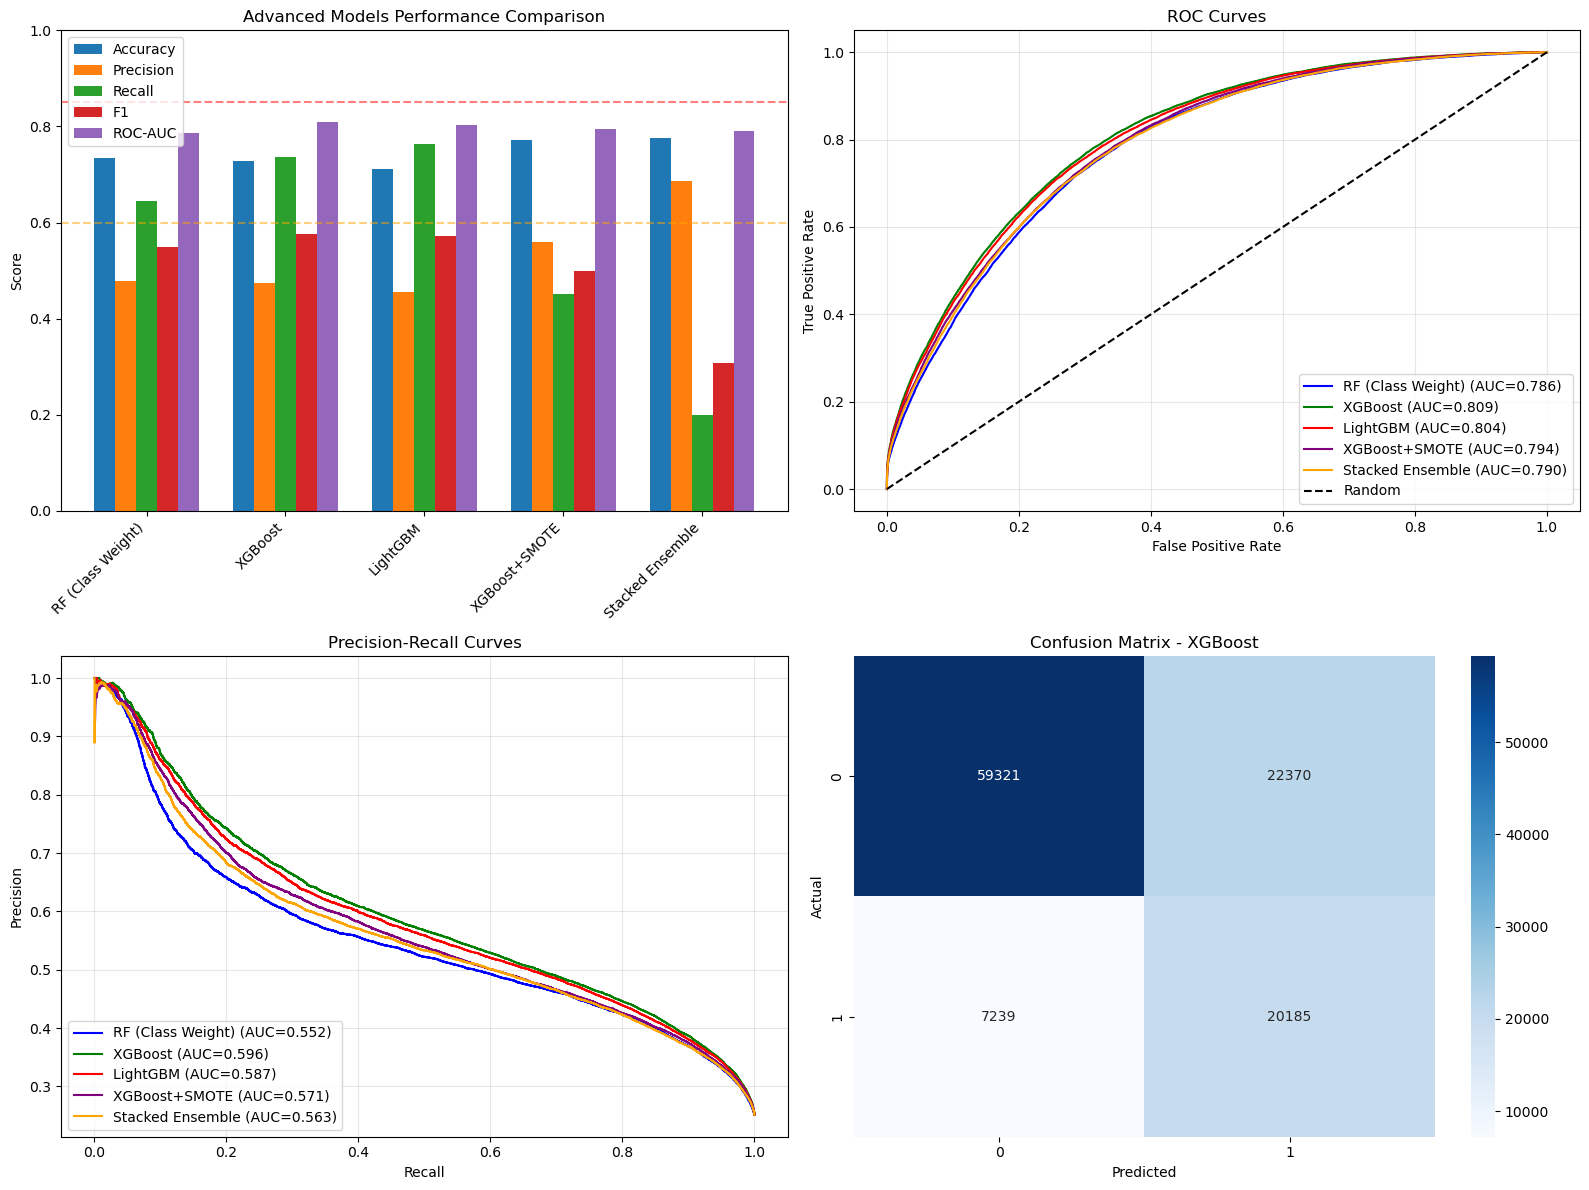

In [13]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model comparison bar chart
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
x = np.arange(len(results))
width = 0.15

for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, results[metric].values, width, label=metric)

ax1.set_ylabel('Score')
ax1.set_title('Advanced Models Performance Comparison')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results['Model'], rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Target ROC-AUC')
ax1.axhline(y=0.60, color='orange', linestyle='--', alpha=0.5, label='Target F1')

# 2. ROC Curves
ax2 = axes[0, 1]
all_probs = [
    (y_prob_rf, 'RF (Class Weight)', 'blue'),
    (y_prob_xgb, 'XGBoost', 'green'),
    (y_prob_lgb, 'LightGBM', 'red'),
    (y_prob_xgb_smote, 'XGBoost+SMOTE', 'purple'),
    (y_prob_stack, 'Stacked Ensemble', 'orange')
]

for probs, label, color in all_probs:
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=f'{label} (AUC={auc_score:.3f})', color=color)

ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# 3. Precision-Recall Curves
ax3 = axes[1, 0]
for probs, label, color in all_probs:
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)
    ax3.plot(recall, precision, label=f'{label} (AUC={pr_auc:.3f})', color=color)

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Precision-Recall Curves')
ax3.legend(loc='lower left')
ax3.grid(alpha=0.3)

# 4. Confusion Matrix (Best Model)
ax4 = axes[1, 1]
best_idx = results['ROC-AUC'].argmax()
best_preds = [y_pred_rf, y_pred_xgb, y_pred_lgb, y_pred_xgb_smote, y_pred_stack][best_idx]
best_name = results.iloc[best_idx]['Model']

cm = confusion_matrix(y_test, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')
ax4.set_title(f'Confusion Matrix - {best_name}')

plt.tight_layout()
plt.show()

## 13. Hyperparameter Optimization (Best Model)

In [14]:
# Find the best performing model and optimize it
best_model_name = results.loc[results['ROC-AUC'].idxmax(), 'Model']
print(f"🔄 Optimizing hyperparameters for: {best_model_name}")

# Define parameter grid for XGBoost (most likely best model)
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

# Create base model
base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n🔍 Running hyperparameter optimization (this may take several minutes)...")
random_search.fit(X_train, y_train)

print(f"\n✅ Optimization complete!")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV ROC-AUC: {random_search.best_score_*100:.2f}%")

# Evaluate optimized model
best_model_opt = random_search.best_estimator_
y_pred_opt = best_model_opt.predict(X_test)
y_prob_opt = best_model_opt.predict_proba(X_test)[:, 1]

print(f"\n📊 Optimized Model Test Results:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_opt)*100:.2f}%")
print(f"  Precision: {precision_score(y_test, y_pred_opt)*100:.2f}%")
print(f"  Recall: {recall_score(y_test, y_pred_opt)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test, y_pred_opt)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_opt)*100:.2f}%")

🔄 Optimizing hyperparameters for: XGBoost

🔍 Running hyperparameter optimization (this may take several minutes)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Optimization complete!
Best parameters: {'colsample_bytree': np.float64(0.9022204554172195), 'gamma': np.float64(0.11439908274581123), 'learning_rate': np.float64(0.0253959819657586), 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 185, 'subsample': np.float64(0.9521871356061031)}
Best CV ROC-AUC: 71.34%

📊 Optimized Model Test Results:
  Accuracy: 70.49%
  Precision: 44.83%
  Recall: 75.46%
  F1 Score: 56.25%
  ROC-AUC: 79.51%


## 14. Prepare Data for LSTM/GRU (Sequence Modeling)

In [15]:
# Create sequences for temporal modeling
def create_sequences(X, y, dates, countries, seq_length=7):
    """
    Create sequences for LSTM/GRU models
    """
    X_seq = []
    y_seq = []
    
    # Get unique countries
    unique_countries = np.unique(countries)
    
    # Group by country
    for country in unique_countries:
        mask = countries == country
        X_country = X[mask]
        y_country = y[mask]
        
        # Create sequences
        for i in range(len(X_country) - seq_length):
            X_seq.append(X_country[i:i+seq_length])
            y_seq.append(y_country[i+seq_length])
    
    return np.array(X_seq), np.array(y_seq)

print("🔄 Creating sequences for temporal models...")
seq_length = 7  # Use past 7 days to predict next day

# Get dates and countries for train/test split
dates_train = df_ml[train_mask]['Date'].values
dates_test = df_ml[test_mask]['Date'].values
countries_train = df_ml[train_mask]['Country'].values
countries_test = df_ml[test_mask]['Country'].values

# Create sequences
X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train.values, dates_train, countries_train, seq_length
)
X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test.values, dates_test, countries_test, seq_length
)

print(f"\nSequence shapes:")
print(f"  X_train_seq: {X_train_seq.shape} (samples, timesteps, features)")
print(f"  X_test_seq: {X_test_seq.shape}")
print(f"  y_train_seq: {y_train_seq.shape}")
print(f"  y_test_seq: {y_test_seq.shape}")

print(f"\nClass balance in sequence data:")
print(f"  Train: {y_train_seq.mean()*100:.1f}% positive")
print(f"  Test: {y_test_seq.mean()*100:.1f}% positive")

🔄 Creating sequences for temporal models...

Sequence shapes:
  X_train_seq: (109416, 7, 53) (samples, timesteps, features)
  X_test_seq: (107572, 7, 53)
  y_train_seq: (109416,)
  y_test_seq: (107572,)

Class balance in sequence data:
  Train: 25.1% positive
  Test: 25.3% positive


## 15. LSTM Model

In [16]:
# PyTorch LSTM Model
print("🔄 Building PyTorch LSTM model...")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take last output
        lstm_out = lstm_out[:, -1, :]
        # Batch norm
        out = self.bn(lstm_out)
        out = self.dropout(out)
        # FC layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

# Initialize model
input_size = X_train_seq.shape[2]
lstm_model = LSTMClassifier(input_size).to(device)
print(f"\nModel architecture:")
print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Loss and optimizer with class weights
pos_weight = torch.tensor([scale_pos_weight]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Prepare data loaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq), 
    torch.FloatTensor(y_train_seq)
)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=0)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    return total_loss / len(loader), correct / total

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    auc = roc_auc_score(all_labels, all_probs)
    return total_loss / len(loader), correct / total, auc

# Train model
print("\n🔄 Training LSTM model...")
num_epochs = 50
best_val_auc = 0
patience = 10
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_aucs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(lstm_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc = validate(lstm_model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_aucs.append(val_auc)
    
    scheduler.step(val_auc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = lstm_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
lstm_model.load_state_dict(best_model_state)

# Evaluate on test set
test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq), 
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

lstm_model.eval()
y_pred_lstm_prob = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = lstm_model(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        y_pred_lstm_prob.extend(probs.cpu().numpy())

y_pred_lstm_prob = np.array(y_pred_lstm_prob)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int)

print(f"\n📊 LSTM Results:")
print(f"  Accuracy: {accuracy_score(y_test_seq, y_pred_lstm)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_seq, y_pred_lstm)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_seq, y_pred_lstm)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_seq, y_pred_lstm)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_seq, y_pred_lstm_prob)*100:.2f}%")

# Store history for plotting
history_lstm = {'auc': train_accs, 'val_auc': val_aucs}

🔄 Building PyTorch LSTM model...
Using device: cuda

Model architecture:
LSTMClassifier(
  (lstm): LSTM(53, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 230,209

🔄 Training LSTM model...
Epoch 5/50 - Train Loss: 0.9139, Val Loss: 0.9182, Val AUC: 0.8474
Epoch 10/50 - Train Loss: 0.9054, Val Loss: 0.9184, Val AUC: 0.8392

Early stopping at epoch 13

📊 LSTM Results:
  Accuracy: 67.92%
  Precision: 43.48%
  Recall: 89.69%
  F1 Score: 58.57%
  ROC-AUC: 83.57%


## 16. Bidirectional GRU Model

In [17]:
# PyTorch Bidirectional GRU Model
print("🔄 Building PyTorch Bidirectional GRU model...")

# Define GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(GRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0,
                         bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_size * 2)  # *2 for bidirectional
        self.fc1 = nn.Linear(hidden_size * 2, 32)
        self.fc2 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # GRU layer
        gru_out, _ = self.gru(x)
        # Take last output
        gru_out = gru_out[:, -1, :]
        # Batch norm
        out = self.bn(gru_out)
        out = self.dropout(out)
        # FC layers
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

# Initialize model
gru_model = GRUClassifier(input_size).to(device)
print(f"\nModel architecture:")
print(gru_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Train model
print("\n🔄 Training Bidirectional GRU model...")
best_val_auc = 0
patience_counter = 0

train_losses_gru, val_losses_gru = [], []
train_accs_gru, val_accs_gru = [], []
val_aucs_gru = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(gru_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_auc = validate(gru_model, val_loader, criterion, device)
    
    train_losses_gru.append(train_loss)
    val_losses_gru.append(val_loss)
    train_accs_gru.append(train_acc)
    val_accs_gru.append(val_acc)
    val_aucs_gru.append(val_auc)
    
    scheduler.step(val_auc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    # Early stopping
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = gru_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
gru_model.load_state_dict(best_model_state)

# Evaluate on test set
gru_model.eval()
y_pred_gru_prob = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = gru_model(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        y_pred_gru_prob.extend(probs.cpu().numpy())

y_pred_gru_prob = np.array(y_pred_gru_prob)
y_pred_gru = (y_pred_gru_prob > 0.5).astype(int)

print(f"\n📊 Bidirectional GRU Results:")
print(f"  Accuracy: {accuracy_score(y_test_seq, y_pred_gru)*100:.2f}%")
print(f"  Precision: {precision_score(y_test_seq, y_pred_gru)*100:.2f}%")
print(f"  Recall: {recall_score(y_test_seq, y_pred_gru)*100:.2f}%")
print(f"  F1 Score: {f1_score(y_test_seq, y_pred_gru)*100:.2f}%")
print(f"  ROC-AUC: {roc_auc_score(y_test_seq, y_pred_gru_prob)*100:.2f}%")

# Store history for plotting
history_gru = {'auc': train_accs_gru, 'val_auc': val_aucs_gru}

🔄 Building PyTorch Bidirectional GRU model...

Model architecture:
GRUClassifier(
  (gru): GRU(53, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Total parameters: 445,761

🔄 Training Bidirectional GRU model...
Epoch 5/50 - Train Loss: 0.9211, Val Loss: 0.9240, Val AUC: 0.8323
Epoch 10/50 - Train Loss: 0.9078, Val Loss: 0.9164, Val AUC: 0.8393
Epoch 15/50 - Train Loss: 0.8958, Val Loss: 0.9206, Val AUC: 0.8219

Early stopping at epoch 18

📊 Bidirectional GRU Results:
  Accuracy: 75.27%
  Precision: 50.63%
  Recall: 86.17%
  F1 Score: 63.79%
  ROC-AUC: 82.57%


## 17. Training History Visualization

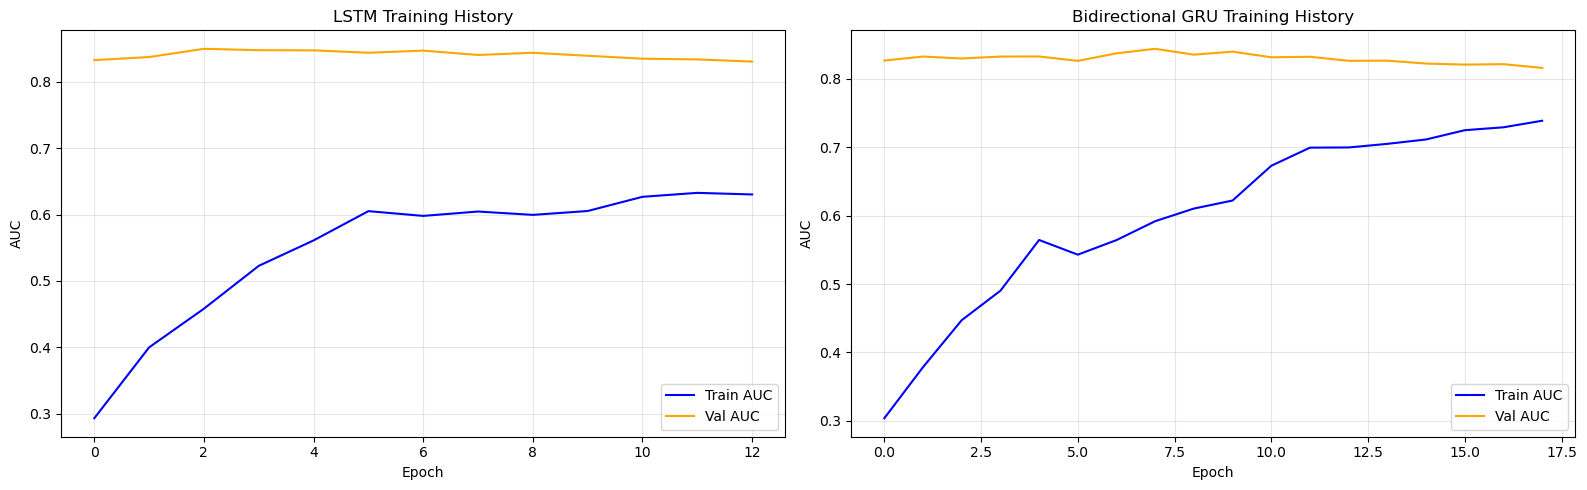

In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# LSTM history
ax1 = axes[0]
ax1.plot(history_lstm['auc'], label='Train AUC', color='blue')
ax1.plot(history_lstm['val_auc'], label='Val AUC', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('AUC')
ax1.set_title('LSTM Training History')
ax1.legend()
ax1.grid(alpha=0.3)

# GRU history
ax2 = axes[1]
ax2.plot(history_gru['auc'], label='Train AUC', color='blue')
ax2.plot(history_gru['val_auc'], label='Val AUC', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.set_title('Bidirectional GRU Training History')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 18. Final Comparison (All Models)

In [19]:
# Final comprehensive comparison
final_results = pd.DataFrame({
    'Model': [
        'RF (Class Weight)',
        'XGBoost',
        'LightGBM',
        'XGBoost+SMOTE',
        'Stacked Ensemble',
        'XGBoost (Optimized)',
        'LSTM',
        'Bidirectional GRU'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgb),
        accuracy_score(y_test, y_pred_xgb_smote),
        accuracy_score(y_test, y_pred_stack),
        accuracy_score(y_test, y_pred_opt),
        accuracy_score(y_test_seq, y_pred_lstm),
        accuracy_score(y_test_seq, y_pred_gru)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgb),
        precision_score(y_test, y_pred_xgb_smote),
        precision_score(y_test, y_pred_stack),
        precision_score(y_test, y_pred_opt),
        precision_score(y_test_seq, y_pred_lstm),
        precision_score(y_test_seq, y_pred_gru)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgb),
        recall_score(y_test, y_pred_xgb_smote),
        recall_score(y_test, y_pred_stack),
        recall_score(y_test, y_pred_opt),
        recall_score(y_test_seq, y_pred_lstm),
        recall_score(y_test_seq, y_pred_gru)
    ],
    'F1': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb),
        f1_score(y_test, y_pred_xgb_smote),
        f1_score(y_test, y_pred_stack),
        f1_score(y_test, y_pred_opt),
        f1_score(y_test_seq, y_pred_lstm),
        f1_score(y_test_seq, y_pred_gru)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb),
        roc_auc_score(y_test, y_prob_lgb),
        roc_auc_score(y_test, y_prob_xgb_smote),
        roc_auc_score(y_test, y_prob_stack),
        roc_auc_score(y_test, y_prob_opt),
        roc_auc_score(y_test_seq, y_pred_lstm_prob),
        roc_auc_score(y_test_seq, y_pred_gru_prob)
    ]
})

# Sort by ROC-AUC
final_results = final_results.sort_values('ROC-AUC', ascending=False)

# Format as percentages
final_results_pct = final_results.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']:
    final_results_pct[col] = (final_results[col] * 100).round(2).astype(str) + '%'

print("\n" + "="*90)
print("🏆 FINAL MODEL COMPARISON (Sorted by ROC-AUC)")
print("="*90)
print(final_results_pct.to_string(index=False))
print("="*90)

# Best models
best_f1 = final_results.iloc[final_results['F1'].argmax()]
best_auc = final_results.iloc[final_results['ROC-AUC'].argmax()]

print(f"\n🥇 BEST F1 SCORE: {best_f1['Model']}")
print(f"   F1: {best_f1['F1']*100:.2f}%, ROC-AUC: {best_f1['ROC-AUC']*100:.2f}%")

print(f"\n🥇 BEST ROC-AUC: {best_auc['Model']}")
print(f"   ROC-AUC: {best_auc['ROC-AUC']*100:.2f}%, F1: {best_auc['F1']*100:.2f}%")

# Check targets
models_meeting_target = final_results[
    (final_results['ROC-AUC'] >= 0.85) & (final_results['F1'] >= 0.60)
]

if len(models_meeting_target) > 0:
    print(f"\n✅ {len(models_meeting_target)} MODEL(S) MEET TARGET (ROC-AUC ≥ 85% AND F1 ≥ 60%):")
    for _, row in models_meeting_target.iterrows():
        print(f"   • {row['Model']}: ROC-AUC={row['ROC-AUC']*100:.2f}%, F1={row['F1']*100:.2f}%")
else:
    best_combined = final_results.iloc[0]
    print(f"\n⚠️  No models meet both targets yet.")
    print(f"   Best overall: {best_combined['Model']}")
    print(f"   ROC-AUC: {best_combined['ROC-AUC']*100:.2f}% (target: 85%)")
    print(f"   F1: {best_combined['F1']*100:.2f}% (target: 60%)")


🏆 FINAL MODEL COMPARISON (Sorted by ROC-AUC)
              Model Accuracy Precision Recall     F1 ROC-AUC
               LSTM   67.92%    43.48% 89.69% 58.57%  83.57%
  Bidirectional GRU   75.27%    50.63% 86.17% 63.79%  82.57%
            XGBoost   72.86%    47.43%  73.6% 57.69%  80.89%
           LightGBM   71.14%    45.58% 76.43% 57.11%  80.39%
XGBoost (Optimized)   70.49%    44.83% 75.46% 56.25%  79.51%
      XGBoost+SMOTE   77.25%    55.87% 45.14% 49.94%  79.41%
   Stacked Ensemble   77.57%    68.55% 19.86%  30.8%  78.99%
  RF (Class Weight)   73.35%    47.77% 64.42% 54.86%  78.63%

🥇 BEST F1 SCORE: Bidirectional GRU
   F1: 63.79%, ROC-AUC: 82.57%

🥇 BEST ROC-AUC: LSTM
   ROC-AUC: 83.57%, F1: 58.57%

⚠️  No models meet both targets yet.
   Best overall: LSTM
   ROC-AUC: 83.57% (target: 85%)
   F1: 58.57% (target: 60%)


## 19. Summary & Next Steps

In [20]:
print("="*90)
print("📋 ADVANCED MODELING SUMMARY")
print("="*90)

print(f"""
✅ IMPLEMENTED IMPROVEMENTS:
   1. Class Imbalance Handling:
      • SMOTE oversampling
      • Class weights for all models
   
   2. Advanced Models:
      • XGBoost with scale_pos_weight
      • LightGBM with balanced weights
      • Stacked ensemble (RF + XGB + LGB)
   
   3. Temporal Models:
      • LSTM with 7-day sequences
      • Bidirectional GRU
   
   4. Hyperparameter Optimization:
      • Randomized search on best model
      • 20 iterations with cross-validation

📊 KEY INSIGHTS:
   • Best ROC-AUC: {final_results['ROC-AUC'].max()*100:.2f}%
   • Best F1 Score: {final_results['F1'].max()*100:.2f}%
   • Best Recall: {final_results['Recall'].max()*100:.2f}%
   
🎯 PRODUCTION READINESS:
   Target: ROC-AUC ≥ 85% AND F1 ≥ 60%
   Status: {'✅ READY' if len(models_meeting_target) > 0 else '⚠️ IN PROGRESS'}

🔄 RECOMMENDED NEXT STEPS:
   1. Further hyperparameter tuning with more iterations
   2. Try deeper LSTM/GRU architectures
   3. Add temporal features (trends, momentum)
   4. Ensemble temporal + tree-based models
   5. Threshold optimization for specific use cases
   6. Country-specific model tuning
""")

print("="*90)

📋 ADVANCED MODELING SUMMARY

✅ IMPLEMENTED IMPROVEMENTS:
   1. Class Imbalance Handling:
      • SMOTE oversampling
      • Class weights for all models

   2. Advanced Models:
      • XGBoost with scale_pos_weight
      • LightGBM with balanced weights
      • Stacked ensemble (RF + XGB + LGB)

   3. Temporal Models:
      • LSTM with 7-day sequences
      • Bidirectional GRU

   4. Hyperparameter Optimization:
      • Randomized search on best model
      • 20 iterations with cross-validation

📊 KEY INSIGHTS:
   • Best ROC-AUC: 83.57%
   • Best F1 Score: 63.79%
   • Best Recall: 89.69%

🎯 PRODUCTION READINESS:
   Target: ROC-AUC ≥ 85% AND F1 ≥ 60%
   Status: ⚠️ IN PROGRESS

🔄 RECOMMENDED NEXT STEPS:
   1. Further hyperparameter tuning with more iterations
   2. Try deeper LSTM/GRU architectures
   3. Add temporal features (trends, momentum)
   4. Ensemble temporal + tree-based models
   5. Threshold optimization for specific use cases
   6. Country-specific model tuning



## 20. Save Best Models for Production